# Sport-73 Classification

Let's do the imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras import (Input, Model, layers, losses, optimizers, metrics, utils, models)

sns.set_style('darkgrid')

Fixing some constants that may need multiple times.

In [2]:
# CONSTANTS
DATA_PATH = '../input/sports-classification'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = (224, 224, 3)
NUM_CLASSES = len(os.listdir(TEST_PATH))

# HYPERPARAMETERS
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-3

Creating the image data generators.

In [3]:
data_generator = image.ImageDataGenerator(rescale = 1./255)
train_generator = data_generator.flow_from_directory(directory= TRAIN_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= BATCH_SIZE)
val_generator = data_generator.flow_from_directory(directory= VAL_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= BATCH_SIZE)
test_generator = data_generator.flow_from_directory(directory= TEST_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= BATCH_SIZE,
                                                    shuffle= False)

Found 10416 images belonging to 73 classes.
Found 365 images belonging to 73 classes.
Found 365 images belonging to 73 classes.


First, we are going to try with a simple CNN architecture and see how it does

In [4]:
def get_cnn_model(IMAGE_SHAPE):
    """
    creates and returns a CNN model.
    """
    # Define the tensors for the two input images
    input_layer = Input(IMAGE_SHAPE)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(input_layer)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(NUM_CLASSES, name="final_dense", activation='softmax')(x)
    return Model(input_layer, outputs)

In [5]:
model = get_cnn_model(IMAGE_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 256)     295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0     

In [6]:
model.compile(optimizer = optimizers.Adam(LEARNING_RATE), 
                loss = losses.categorical_crossentropy, 
                metrics = ['accuracy'])

In [7]:
history = model.fit(train_generator, validation_data= val_generator, epochs = EPOCHS)

Epoch 1/50
326/326 [==============================] - 66s 178ms/step - loss: 4.1909 - accuracy: 0.0456 - val_loss: 3.4212 - val_accuracy: 0.1726
Epoch 2/50
326/326 [==============================] - 33s 102ms/step - loss: 2.7708 - accuracy: 0.3360 - val_loss: 3.2153 - val_accuracy: 0.2438
Epoch 3/50
326/326 [==============================] - 33s 101ms/step - loss: 1.3085 - accuracy: 0.6714 - val_loss: 4.1931 - val_accuracy: 0.2466
Epoch 4/50
326/326 [==============================] - 34s 105ms/step - loss: 0.4511 - accuracy: 0.8847 - val_loss: 6.2927 - val_accuracy: 0.2329
Epoch 5/50
326/326 [==============================] - 32s 99ms/step - loss: 0.1828 - accuracy: 0.9564 - val_loss: 8.9907 - val_accuracy: 0.2247
Epoch 6/50
326/326 [==============================] - 32s 98ms/step - loss: 0.0935 - accuracy: 0.9814 - val_loss: 10.1276 - val_accuracy: 0.2164
Epoch 7/50
326/326 [==============================] - 32s 99ms/step - loss: 0.0769 - accuracy: 0.9856 - val_loss: 9.8003 - val_accu

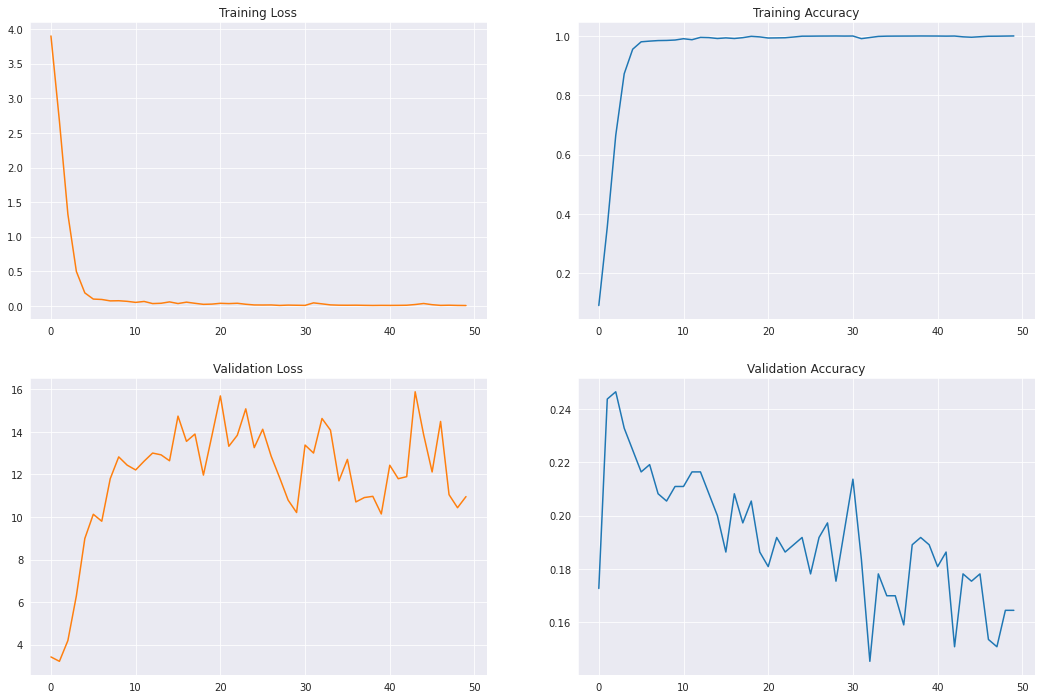

In [8]:
plt.figure(figsize = (18,12))
plt.subplot(2,2,1)
plt.title('Training Loss')
plt.plot(history.history['loss'], color = 'tab:orange')
plt.subplot(2,2,2)
plt.title('Training Accuracy')
plt.plot(history.history['accuracy'], color = 'tab:blue')
plt.subplot(2,2,3)
plt.title('Validation Loss')
plt.plot(history.history['val_loss'], color = 'tab:orange')
plt.subplot(2,2,4)
plt.title('Validation Accuracy')
plt.plot(history.history['val_accuracy'], color = 'tab:blue');

In [9]:
model.save('model1')

In [10]:
model.evaluate(test_generator)

12/12 [==============================] - 2s 173ms/step - loss: 9.5120 - accuracy: 0.1808


[9.511969566345215, 0.18082191050052643]

As we can see, the results look horrible and whatever we are doing is not working. 
We should now try with some transfer learning and see if previous learning helps with the results.

- We will be using MobileNet architecture with some added modifications.
- Image augmentation can also be useful for the model, especially one with 73 classes.

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [12]:
train_data_generator = image.ImageDataGenerator(
                                            rotation_range=30,
                                            zoom_range=0.15,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.15,
                                            horizontal_flip=True,
                                            fill_mode="nearest",
                                            preprocessing_function=preprocess_input
                                            )

test_data_generator = image.ImageDataGenerator(
                                            preprocessing_function=preprocess_input
                                            )

train_generator = train_data_generator.flow_from_directory(directory= TRAIN_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= BATCH_SIZE)
val_generator = train_data_generator.flow_from_directory(directory= VAL_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= BATCH_SIZE)
test_generator = test_data_generator.flow_from_directory(directory= TEST_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= BATCH_SIZE)

Found 10416 images belonging to 73 classes.
Found 365 images belonging to 73 classes.
Found 365 images belonging to 73 classes.


Let's just add two Dense layers to the architecture.

In [13]:
class ModifiedMobileNet():
    '''
    This class creates the mobilenet model.
    '''
    def __init__(self, input_shape, nb_classes):
        self.input_shape = input_shape
        self.nb_classes = nb_classes
        
    def get_model(self, unfreeze_layers = None, lr_rate = 0.001):
        # load base model
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        
        # freezing the layers
        for layer in (base_model.layers) if not unfreeze_layers else (base_model.layers[:-int(unfreeze_layers)]):
            layer.trainable = False
            
        inputs = Input(shape=self.input_shape)
        x = base_model(inputs, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.1)(x)
        outputs = layers.Dense(self.nb_classes, activation='softmax')(x)
        model = Model(inputs, outputs)
        
        # model compilation
        optimizer = optimizers.Adam(learning_rate=lr_rate)
        model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
        return model

 We'll keep the base MobileNet frozen completely and only the added layers will learn from our dataset.

In [14]:
mobilenet = ModifiedMobileNet(input_shape= IMAGE_SHAPE, nb_classes= NUM_CLASSES)
model = mobilenet.get_model(unfreeze_layers=0, lr_rate= LEARNING_RATE)

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
model.compile(optimizer = optimizers.Adam(LEARNING_RATE), 
                loss = losses.categorical_crossentropy, 
                metrics = ['accuracy'])

In [16]:
history = model.fit(train_generator, validation_data= val_generator, epochs = EPOCHS)

Epoch 1/50
326/326 [==============================] - 137s 412ms/step - loss: 3.2087 - accuracy: 0.2342 - val_loss: 1.0190 - val_accuracy: 0.7068
Epoch 2/50
326/326 [==============================] - 136s 416ms/step - loss: 1.2554 - accuracy: 0.6339 - val_loss: 0.7368 - val_accuracy: 0.7945
Epoch 3/50
326/326 [==============================] - 136s 418ms/step - loss: 0.9643 - accuracy: 0.7080 - val_loss: 0.5848 - val_accuracy: 0.8329
Epoch 4/50
326/326 [==============================] - 134s 412ms/step - loss: 0.8392 - accuracy: 0.7495 - val_loss: 0.6358 - val_accuracy: 0.7918
Epoch 5/50
326/326 [==============================] - 138s 422ms/step - loss: 0.7764 - accuracy: 0.7648 - val_loss: 0.5529 - val_accuracy: 0.8247
Epoch 6/50
326/326 [==============================] - 138s 424ms/step - loss: 0.7050 - accuracy: 0.7840 - val_loss: 0.4721 - val_accuracy: 0.8603
Epoch 7/50
326/326 [==============================] - 137s 421ms/step - loss: 0.6415 - accuracy: 0.8000 - val_loss: 0.4825 -

In [17]:
model.save('model2')

In [18]:
model.evaluate(test_generator)

12/12 [==============================] - 2s 149ms/step - loss: 0.2141 - accuracy: 0.9178


[0.21407487988471985, 0.9178082346916199]

We can observe from the above plots how much we have improved by using the knowledge that MobileNet already has with some new learning from the added dense layers.

Let's check the Precision and Recall of Both architectures.  
Since there are 73 classes, we will calculated weighted Precision and Recall for ease of understanding.

In [19]:
test_generator = data_generator.flow_from_directory(directory= TEST_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'sparse',
                                                    batch_size= 365,
                                                    shuffle= False)

Found 365 images belonging to 73 classes.


In [20]:
test_images, test_labels = test_generator.next()

In [21]:
default_model = models.load_model('model1/')
improved_model = models.load_model('model2/')

In [22]:
default_predictions= default_model.predict(test_images).argmax(axis = 1)
improved_predictions= improved_model.predict(test_images).argmax(axis = 1)

In [23]:
from sklearn.metrics import precision_score, recall_score

In [24]:
def_precision, def_recall = (precision_score(test_labels, default_predictions, average= 'weighted'),
                            recall_score(test_labels, default_predictions, average= 'weighted'))
imp_precision, imp_recall = (precision_score(test_labels, improved_predictions, average= 'weighted'),
                            recall_score(test_labels, improved_predictions, average= 'weighted'))

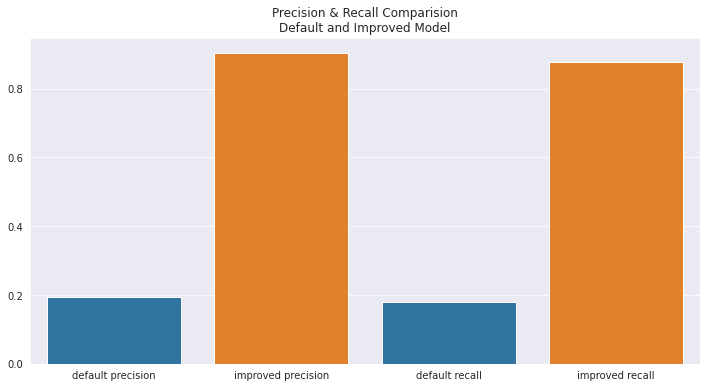

In [25]:
colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
customPalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (12,6))
plt.title('Precision & Recall Comparision\nDefault and Improved Model')
f = sns.barplot(x = list(range(4)), y = [def_precision, imp_precision, def_recall, imp_recall], palette=customPalette)
plt.xticks(f.get_xticks(), labels = ['default precision', 'improved precision', 'default recall', 'improved recall']);

That's it for this one. Thanks!
Any comments, suggestions or corrections are welcome.

Follow me on Twitter [@capeandcode](https://www.twitter.com/capeandcode).      

Connect with me [here](https://prashantbrahmbhatt.bio.link/).